In [71]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import f1_score, accuracy_score, log_loss, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
import math
import pickle
import time
from scipy import stats
import sklearn.preprocessing as sp

In [39]:
print(sklearn.__version__)

0.19.1


In [26]:
target = 'label'
scoring_metric = 'roc_auc'
num_fold = 5 # 5-fold cross-validation

# Create dataframe for modelling

Load feature file

In [3]:
df_agg_features = pd.read_csv('../dataset/train/part-00000-1aa27771-a36d-4141-bc7e-bfc21cc5f625-c000.csv')
df_agg_features.shape

(20000, 43)

In [4]:
df_agg_features.head()

,bookingID,travel_sec,speed_sub_t5_max,speed_sub_t5_std,speed_avg,speed_med,speed_max,disp_sub_t5_90perc,accx_sub_t5_cnt70perc,speed_80perc,...,speed_max_inc_num,accx_max_inc_num,accy_max_inc_num,accz_max_inc_num,gyrox_max_inc_num,gyroy_max_inc_num,gyroz_max_inc_num,acc3d_max_inc_num,gyro3d_max_inc_num,acc3dgyro3d_max_inc_num
0,1005022347400,674.0,2.140780,0.508607,5.956608,4.250000,18.78280,25.660000,153,12.524000,...,7.0,510.0,510.0,510.0,398.0,336.0,306.0,4.0,6.0,7.0
1,1013612281858,660.0,1.581360,0.413025,6.413065,5.940000,17.10100,9.148560,198,11.002000,...,12.0,659.0,659.0,659.0,659.0,659.0,659.0,6.0,6.0,5.0
2,1073741824023,960.0,1.101222,0.240450,14.535230,20.871590,26.27040,1.600000,287,24.784372,...,32.0,509.0,693.0,693.0,160.0,296.0,270.0,5.0,7.0,5.0
3,1099511627844,884.0,1.245280,0.275985,16.166441,17.629999,27.76800,2.275961,266,20.301999,...,15.0,885.0,885.0,885.0,748.0,748.0,748.0,6.0,6.0,6.0
4,1108101562504,374.0,1.295797,0.379069,3.732354,3.645418,14.00994,7.920000,113,6.402391,...,16.0,375.0,375.0,375.0,152.0,155.0,159.0,4.0,6.0,5.0


In [5]:
list(df_agg_features)

['bookingID',
 'travel_sec',
 'speed_sub_t5_max',
 'speed_sub_t5_std',
 'speed_avg',
 'speed_med',
 'speed_max',
 'disp_sub_t5_90perc',
 'accx_sub_t5_cnt70perc',
 'speed_80perc',
 'speed_90perc',
 'speed_sub_t5_90perc',
 'disp_sub_t5_avg',
 'accy_sub_t5_cnt70perc',
 'speed_std',
 'accz_sub_t5_cnt70perc',
 'speed_sub_t5_cnt70perc',
 'disp_sub_t5_max',
 'speed_sub_t5_med',
 'gyroy_med',
 'gyroz_med',
 'accx_max',
 'gyrox_sub_t5_cnt70perc',
 'speed_sub_t5_avg',
 'disp_sub_t5_80perc',
 'disp_sub_t5_std',
 'accz_std',
 'gyrox_med',
 'accz_max',
 'accy_max',
 'accx_sub_t5_med',
 'speed_sub_t5_80perc',
 'gyroy_sub_t5_cnt70perc',
 'speed_max_inc_num',
 'accx_max_inc_num',
 'accy_max_inc_num',
 'accz_max_inc_num',
 'gyrox_max_inc_num',
 'gyroy_max_inc_num',
 'gyroz_max_inc_num',
 'acc3d_max_inc_num',
 'gyro3d_max_inc_num',
 'acc3dgyro3d_max_inc_num']

Load label file

In [6]:
df_label=pd.read_csv('../labels/train/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')
df_label.shape

(20018, 2)

In [7]:
# Check duplicated bookingIDs in label data
df_label[df_label.bookingID.isin(df_label[df_label.bookingID.duplicated()].bookingID)
        ].sort_values(by=['bookingID', 'label'])

,bookingID,label
12463,13,0
12602,13,1
5295,154618822837,0
2351,154618822837,1
6212,223338299461,0
11215,223338299461,1
19936,395136991308,0
6121,395136991308,1
8472,403726925929,0
17623,403726925929,1


In [8]:
# Exclude bookingIDs whose label is not unique because we don't know actual information
df_label = df_label[~(df_label.bookingID.duplicated())]
df_label.shape

(20000, 2)

In [9]:
# Check if duplicated bookingIDs has been removed
df_label[df_label.bookingID.isin(df_label[df_label.bookingID.duplicated()].bookingID)
        ].sort_values(by=['bookingID', 'label'])

,bookingID,label


In [10]:
# Merge features and label data
df=df_agg_features.merge(df_label, how='inner', on='bookingID')
df.shape

(20000, 44)

In [11]:
df.bookingID.nunique()

20000

# Create training and testing dataset

In [13]:
df[target].value_counts()

0    15007
1     4993
Name: label, dtype: int64

In [14]:
df_merge=df.drop('bookingID', axis=1)

In [15]:
X = df_merge.iloc[:,0:len(df_merge.columns)-1]
y = df_merge[target]

In [16]:
X.head()

,travel_sec,speed_sub_t5_max,speed_sub_t5_std,speed_avg,speed_med,speed_max,disp_sub_t5_90perc,accx_sub_t5_cnt70perc,speed_80perc,speed_90perc,...,speed_max_inc_num,accx_max_inc_num,accy_max_inc_num,accz_max_inc_num,gyrox_max_inc_num,gyroy_max_inc_num,gyroz_max_inc_num,acc3d_max_inc_num,gyro3d_max_inc_num,acc3dgyro3d_max_inc_num
0,674.0,2.140780,0.508607,5.956608,4.250000,18.78280,25.660000,153,12.524000,15.525000,...,7.0,510.0,510.0,510.0,398.0,336.0,306.0,4.0,6.0,7.0
1,660.0,1.581360,0.413025,6.413065,5.940000,17.10100,9.148560,198,11.002000,13.652000,...,12.0,659.0,659.0,659.0,659.0,659.0,659.0,6.0,6.0,5.0
2,960.0,1.101222,0.240450,14.535230,20.871590,26.27040,1.600000,287,24.784372,25.295819,...,32.0,509.0,693.0,693.0,160.0,296.0,270.0,5.0,7.0,5.0
3,884.0,1.245280,0.275985,16.166441,17.629999,27.76800,2.275961,266,20.301999,24.891999,...,15.0,885.0,885.0,885.0,748.0,748.0,748.0,6.0,6.0,6.0
4,374.0,1.295797,0.379069,3.732354,3.645418,14.00994,7.920000,113,6.402391,8.375863,...,16.0,375.0,375.0,375.0,152.0,155.0,159.0,4.0,6.0,5.0


In [17]:
X.shape

(20000, 42)

In [18]:
y.sum()/X.shape[0]

0.24965

In [19]:
X.columns

Index(['travel_sec', 'speed_sub_t5_max', 'speed_sub_t5_std', 'speed_avg',
       'speed_med', 'speed_max', 'disp_sub_t5_90perc', 'accx_sub_t5_cnt70perc',
       'speed_80perc', 'speed_90perc', 'speed_sub_t5_90perc',
       'disp_sub_t5_avg', 'accy_sub_t5_cnt70perc', 'speed_std',
       'accz_sub_t5_cnt70perc', 'speed_sub_t5_cnt70perc', 'disp_sub_t5_max',
       'speed_sub_t5_med', 'gyroy_med', 'gyroz_med', 'accx_max',
       'gyrox_sub_t5_cnt70perc', 'speed_sub_t5_avg', 'disp_sub_t5_80perc',
       'disp_sub_t5_std', 'accz_std', 'gyrox_med', 'accz_max', 'accy_max',
       'accx_sub_t5_med', 'speed_sub_t5_80perc', 'gyroy_sub_t5_cnt70perc',
       'speed_max_inc_num', 'accx_max_inc_num', 'accy_max_inc_num',
       'accz_max_inc_num', 'gyrox_max_inc_num', 'gyroy_max_inc_num',
       'gyroz_max_inc_num', 'acc3d_max_inc_num', 'gyro3d_max_inc_num',
       'acc3dgyro3d_max_inc_num'],
      dtype='object')

In [20]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=1021)
print(sss.get_n_splits(X, y))
print(sss)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

2
StratifiedShuffleSplit(n_splits=2, random_state=1021, test_size=0.3,
            train_size=None)


In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14000, 42)
(6000, 42)
(14000,)
(6000,)


In [22]:
print(y_train.value_counts())
print(y_test.value_counts())

0    10505
1     3495
Name: label, dtype: int64
0    4502
1    1498
Name: label, dtype: int64


In [23]:
# Check positive/negative ratio in target variable
print(1.0*y_train.value_counts()[1]/y_train.value_counts()[0])
print(1.0*y_test.value_counts()[1]/y_test.value_counts()[0])

0.3326987148976678
0.33274100399822304


In [24]:
# Transform DMatrix type
dtrain = xgb.DMatrix(X_train,label=y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test.as_matrix(),label=y_test.tolist(), feature_names=X_train.columns)

# Run cross-validation for Model selection

In [32]:
start_time_total = time.time()
print('Run ' + str(num_fold) + '-fold cross-validation')
print('Metric is ' + scoring_metric)
start_time_cv = time.time()

# transform DMatrix type
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test.as_matrix(),label=y_test.tolist(), feature_names=X_train.columns)
xgb_model = xgb.XGBClassifier()
xgb_model.get_params().keys()
params_cv={'objective': ['binary:logistic'],
           'learning_rate': [0.001],
            'gamma': [0],
            'max_depth': [5, 7],
            'min_child_weight': [1],
            'max_delta_step' : [1],
            'subsample': [0.5, 1],
            'silent': [1], 
            'colsample_bytree': [0.5, 0.7],
            'colsample_bylevel': [0.5, 0.7],
            'nthread': [16],
            'scale_pos_weight': [1],
            'n_estimators': [500],
            'seed': [1021]
    }
stratified_gscv = StratifiedKFold(n_splits=num_fold, random_state=1021, shuffle=False)
gscv = GridSearchCV(xgb_model, params_cv, scoring=scoring_metric, cv=stratified_gscv.split(X_train, y_train))
gscv.fit(X_train, y_train)

print('CV score: ' + scoring_metric + ' = ' + str(gscv.best_score_))
print('Hyperparameters of selected model:')
print(gscv.best_estimator_.get_params())

Run 5-fold cross-validation
Metric is roc_auc
CV score: roc_auc = 0.7218212051077252
Hyperparameters of selected model:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.5, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.001, 'max_delta_step': 1, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': 16, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 1021, 'silent': 1, 'subsample': 1, 'verbosity': 1}


# Build XGBoost model and evaluation by testing dataset

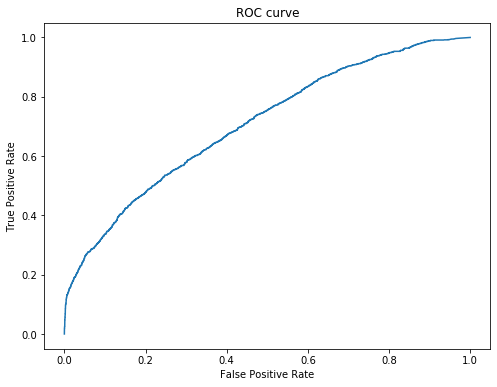

Test AUC: 0.7075910928772793
Test F1-score: 0.2867924528301886
Test accuracy: 0.7795


In [34]:
#train model by using tuned hyper-parameter
model_fulldata=xgb.train(gscv.best_estimator_.get_params(), dtrain, num_boost_round=500)

predicted_prob = model_fulldata.predict(dtest)
fpr_test, tpr_test, thresholds_test= roc_curve(y_test, predicted_prob)

# plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_test, tpr_test)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#calculate AUC
roc_auc_tmp = roc_auc_score(y_test, predicted_prob)
print('Test AUC: ' + str(roc_auc_tmp))

#calculate F1_score
y_test_val = y_test.get_values()
y_bin = [1. if y_cont > 0.5 else 0. for y_cont in predicted_prob] # binaryzing output
f1_tmp = f1_score(y_test_val, y_bin)
print('Test F1-score: ' + str(f1_tmp))

#calculate accuracy
accuracy_tmp = accuracy_score(y_test_val, y_bin)
print('Test accuracy: ' + str(accuracy_tmp))

In [62]:
# Save XGBoost model as a pickle file
pickle.dump(model_fulldata, open('../model/xgb_model_fulldata_allfeatures_for_notebook.pkl', 'wb'))

# Plot feature importance

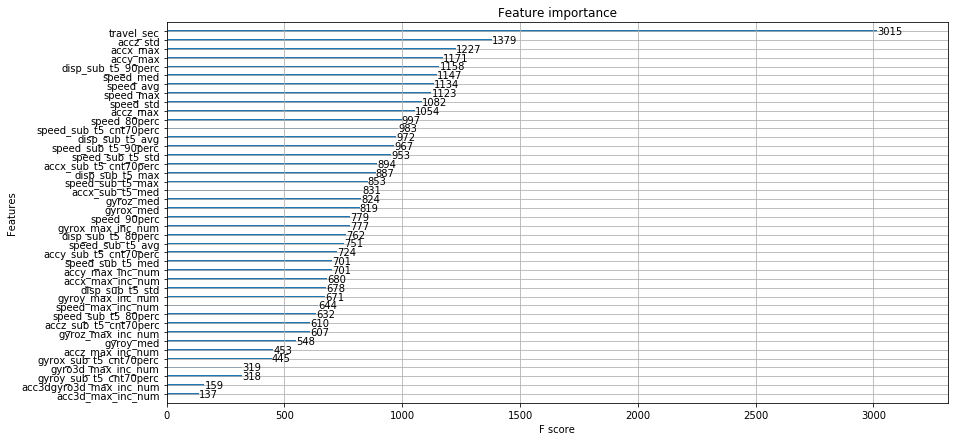

In [41]:
mpl.rcParams["figure.figsize"] = (14, 7)
xgb.plot_importance(booster=model_fulldata)

Top 10 important features are as follows:  
1. travel_sec  
2. accz_std  
3. accx_max  
4. accy_max  
5. disp_sub_t5_90perc  
6. speed_med  
7. speed_avg  
8. speed_max  
9. speed_std  
10. accz_max  

In [55]:
for k, v in sorted(model_fulldata.get_fscore().items(), key=lambda x:x[1], reverse=True):
    print(k, v)

travel_sec 3015
accz_std 1379
accx_max 1227
accy_max 1171
disp_sub_t5_90perc 1158
speed_med 1147
speed_avg 1134
speed_max 1123
speed_std 1082
accz_max 1054
speed_80perc 997
speed_sub_t5_cnt70perc 983
disp_sub_t5_avg 972
speed_sub_t5_90perc 967
speed_sub_t5_std 953
accx_sub_t5_cnt70perc 894
disp_sub_t5_max 887
speed_sub_t5_max 853
accx_sub_t5_med 831
gyroz_med 824
gyrox_med 819
speed_90perc 779
gyrox_max_inc_num 777
disp_sub_t5_80perc 762
speed_sub_t5_avg 751
accy_sub_t5_cnt70perc 724
accy_max_inc_num 701
speed_sub_t5_med 701
accx_max_inc_num 680
disp_sub_t5_std 678
gyroy_max_inc_num 671
speed_max_inc_num 644
speed_sub_t5_80perc 632
accz_sub_t5_cnt70perc 610
gyroz_max_inc_num 607
gyroy_med 548
accz_max_inc_num 453
gyrox_sub_t5_cnt70perc 445
gyro3d_max_inc_num 319
gyroy_sub_t5_cnt70perc 318
acc3dgyro3d_max_inc_num 159
acc3d_max_inc_num 137


In [56]:
confusion_matrix(y_true=y_test_val, y_pred=y_bin)

array([[4411,   91],
       [1232,  266]])

In [114]:
feature_list=[]
cnt=0
for k, v in sorted(model_fulldata.get_fscore().items(), key=lambda x:x[1], reverse=True):
    print(k, v)
    feature_list.append(k)
    cnt=cnt+1
    if cnt>9:
        break

travel_sec 3015
accz_std 1379
accx_max 1227
accy_max 1171
disp_sub_t5_90perc 1158
speed_med 1147
speed_avg 1134
speed_max 1123
speed_std 1082
accz_max 1054


In [115]:
feature_list.append('label')
df_merge_plot = df_merge[feature_list]
df_merge_plot.head()

,travel_sec,accz_std,accx_max,accy_max,disp_sub_t5_90perc,speed_med,speed_avg,speed_max,speed_std,accz_max,label
0,674.0,1.348383,2.516610,1.242720,25.660000,4.250000,5.956608,18.78280,6.222296,3.486104,0
1,660.0,0.931186,1.684914,1.839616,9.148560,5.940000,6.413065,17.10100,4.778845,1.972231,0
2,960.0,0.887025,1.804365,1.711517,1.600000,20.871590,14.535230,26.27040,10.843799,2.135343,0
3,884.0,0.770171,1.755684,1.946853,2.275961,17.629999,16.166441,27.76800,6.707763,1.990804,0
4,374.0,1.441744,2.338543,1.764192,7.920000,3.645418,3.732354,14.00994,3.830735,3.883896,1


In [116]:
feature_list.pop(-1)
feature_list

['travel_sec',
 'accz_std',
 'accx_max',
 'accy_max',
 'disp_sub_t5_90perc',
 'speed_med',
 'speed_avg',
 'speed_max',
 'speed_std',
 'accz_max']

travel_sec


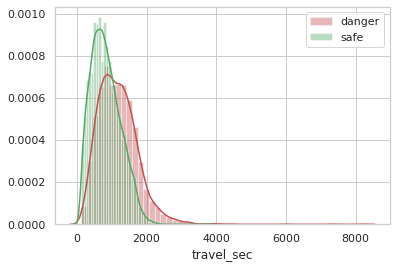

accz_std


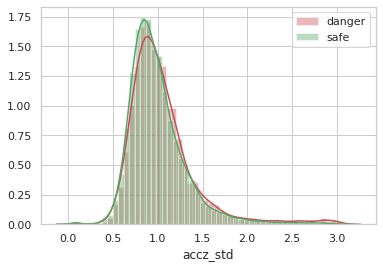

accx_max


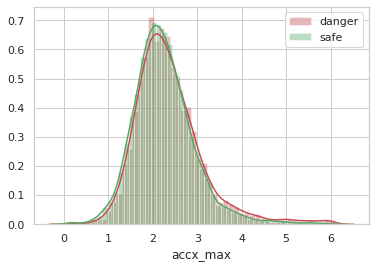

accy_max


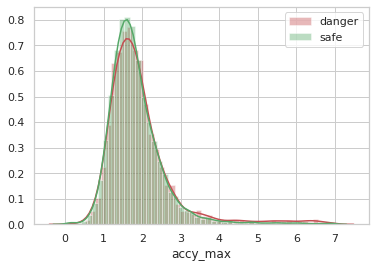

disp_sub_t5_90perc


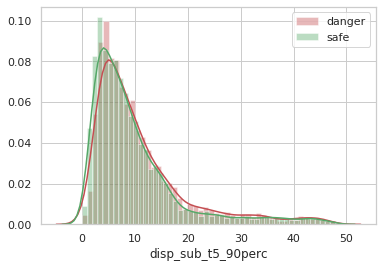

speed_med


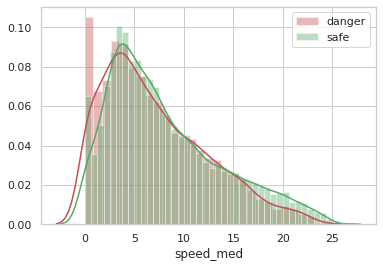

speed_avg


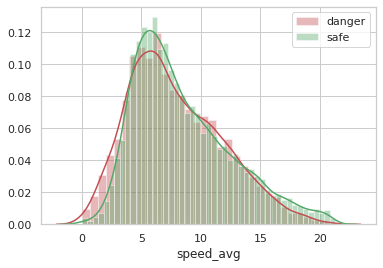

speed_max


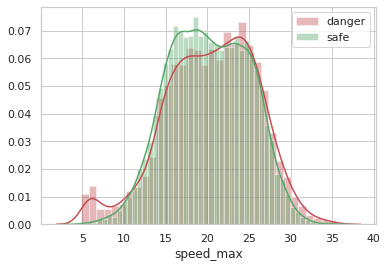

speed_std


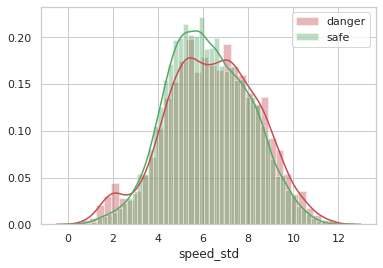

accz_max


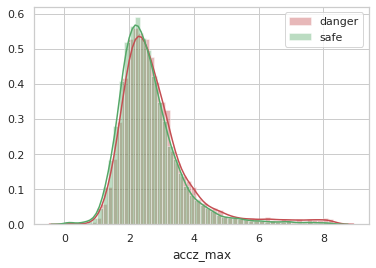

In [117]:
for _colname in feature_list:
    print(_colname)
    # Remove outliers in a column
    df_merge_plot_tmp = df_merge_plot[
        np.abs(df_merge_plot[_colname] - df_merge_plot[_colname].mean()
                    ) <= (3*df_merge_plot[_colname].std())] 

    sns.distplot(df_merge_plot_tmp[_colname][df_merge_plot_tmp[target]==1], color='r', label = 'danger')
    sns.distplot(df_merge_plot_tmp[_colname][df_merge_plot_tmp[target]==0], color='g', label = 'safe')
    plt.legend(loc='best')
    fig.suptitle('Histograms for '+ _colname)
    fig.tight_layout()
    fig.subplots_adjust(top=0.75)
    plt.show()